In [25]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import math
import cvxopt.solvers
import numpy.linalg as la
import logging

from sklearn.utils import shuffle
from tqdm import tqdm_notebook 

In [26]:
class Chromosome:
 
    def __init__(self,  vardim, bound):

        self.vardim = vardim
        self.bound = bound
        self.fitness = 0.
 
    def generate(self):

        len = self.vardim
        rnd1 = np.random.random(size=len)-0.5
        rnd2 = np.random.random(size=len)-0.5
        self.chrom = np.zeros(len)
        self.cig = np.zeros(len)
        for i in range(0, len):
            self.chrom[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd1[i]
            self.cig[i] = self.bound[0, i] + \
                (self.bound[1, i] - self.bound[0, i]) * rnd2[i]
        
    def calculateFitness(self,dataset):
        
        self.fitness = SVMResult(
            self.vardim, self.chrom, self.bound, dataset)
        
    def print_(self):
        
        print("chrome".format(self.chrom))
        print("cigma".format(self.cig))

In [39]:
class GA:
 
    def __init__(self, sizepop, vardim, bound, MAXGEN, params, k, patience):
        
        self.q = 0
        self.patience = patience  #引入早停
        self.remain = sizepop
        self.realsize = self.remain
        self.sizepop = self.remain*k
        self.MAXGEN = MAXGEN
        self.vardim = vardim
        self.bound = bound
        self.k = k
        self.population = []
        self.fitness = np.zeros((self.sizepop, 1))
        self.trace = np.zeros((self.MAXGEN, 2))
        self.params = params
        self.dataset = self.creat_dataset(pd.read_csv("diabetes.csv"))
        self.lr = 0.1
        self.flag = 0
        self.resize = []
    def creat_dataset(self, df):
        
        df = shuffle(df)
        size = len(df)
        df['split'] = 0
        df.iloc[0:math.ceil(0.7*size),-1] = 'train'
        #df.iloc[math.ceil(0.7*size):math.ceil(0.85*size), -1] = 'test'
        df.iloc[math.ceil(0.15*size):size, -1] = 'val' #调高验证集比例

        return df
 
    def initialize(self):
        
        for i in range(0, self.remain):
            chrom = Chromosome(self.vardim, self.bound)
            chrom.generate()
            self.population = np.append(self.population, chrom)
        self.population = np.array(self.population) 
        
    def evaluate(self):
        
        fitness = []
        for i in tqdm_notebook(range(0, self.realsize)):
            self.population[i].calculateFitness(self.dataset)
            #print("###/n")
            fitness.append(self.population[i].fitness)
        self.fitness = np.array(fitness)
        best_idx = np.argmax(self.fitness)
        self.best_score = self.fitness[best_idx]
        self.best = self.population[best_idx]
        
    def start(self):
        
        self.t = 0
        self.initialize()
        self.evaluate()
        p = 0
        self.best_fitness = 0
        self.last_best = self.best_fitness
        best = np.max(self.fitness)
        bestIndex = np.argmax(self.fitness)
        self.best = copy.deepcopy(self.population[bestIndex])
        self.ever_best = self.best
        self.avefitness = np.mean(self.fitness)
        self.trace[self.t, 0] = self.best_fitness
        self.trace[self.t, 1] = self.avefitness
        while (self.t < self.MAXGEN - 1):
            if self.best.fitness>self.best_fitness:
                self.p=0
                self.ever_best = self.best
                self.best_fitness = self.ever_best.fitness
            elif self.best.fitness==self.ever_best.fitness\
                    or self.best.fitness==self.last_best:
                print(p)
                p += 1
            if p==self.patience:
                self.q+=5
                self.lr = 0.1
                self.k += 1
                self.remain += 5
                self.realsize = self.remain
                self.sizepop = self.remain*self.k
                p = 0
                self.flag = 1
                print("学习率重置")
                self.resize.append(self.t)
            print("第{}代".format(self.t))
            print("本代最好的染色体: {}".format(self.population[bestIndex].chrom))
            print("本代最高分: {}".format(self.population[bestIndex].fitness))
            print("历史最高分: {}".format(self.best_fitness))
            self.t += 1
            self.crossover()
            self.mutation()
            self.evaluate()
            self.selection()
            self.last_best = self.best.fitness
            best = np.max(self.fitness)
            bestIndex = np.argmax(self.fitness)
            self.best = copy.deepcopy(self.population[bestIndex])
            self.avefitness = np.mean(self.fitness)
            self.trace[self.t, 0] = self.best_fitness
            self.trace[self.t, 1] = self.avefitness
            
        print(self.best.chrom)
        self.show()
 
    def selection(self):
        
        sort_idx = np.argsort(self.fitness, axis=0).reshape(1,-1)[0]
        top_idx = sort_idx[len(self.fitness)-self.remain-1:-1]
        new_fitness = copy.deepcopy(self.fitness[top_idx])
        self.fitness = new_fitness
        new = copy.deepcopy(self.population[top_idx]) 
        self.population  = new
        self.realsize = len(self.population)
    
    """
     def selection(self):
     
        #软选择
        #print("max: {}".format(np.argmax(self.fitness)))
        #print(self.fitness)
        sort_idx = np.argsort(self.fitness, axis=0).reshape(1,-1)[0]
        #print(sort_idx[0:self.remain])
        new = copy.deepcopy(self.population[sort_idx[0:self.remain]])
        self.population  = new
        self.realsize = len(self.population)
        #print(self.realsize)
    """
    
    def crossover(self):
        
        newpop = []
        for i in range(self.sizepop-self.remain-self.q+5):
            if self.flag==1:
                idx1 = random.randint(0, self.remain - 5 - 1)
                idx2 = random.randint(0, self.remain - 5 - 1)
                flag = 0
            else:
                idx1 = random.randint(0, self.remain - 1)
                idx2 = random.randint(0, self.remain - 1)
            while idx2 == idx1:
                idx2 = random.randint(0, self.remain - 1)
            new = copy.deepcopy(self.population[idx1])
            new.chrom += self.population[idx2].chrom
            new.chrom /= 2
            new.cig += self.population[idx2].cig
            new.cig /= 2
            self.population = np.append(self.population, new)
            
        for i in range(self.remain+self.q-1):
            new = Chromosome(self.vardim, self.bound)
            new.generate()
            self.population = np.append(self.population, new)
        self.realsize = len(self.population)
        
    def mutation(self):
        
        newpop = []
        self.lr *= 0.9
        for i in range(0, self.sizepop-1):
            p = random.random()-0.5
            newpop.append(copy.deepcopy(self.population[i]))
            rand = random.random()-0.5
            for j in range(0, self.vardim):
                
                randn = random.random()-0.5
                flag = 1
                while newpop[i].cig[j]==0 or flag==1:
                    flag = 0
                    newpop[i].cig[j] = newpop[i].cig[j]*np.exp(rand+randn)
                newpop[i].chrom[j] = newpop[i].\
                    cig[j]+newpop[i].cig[j]*randn*self.lr 
                
        newpop.append(self.best)        
        
        self.population = np.array(newpop)
        self.realsize = len(self.population)
 
    def show(self):
        
        x = np.arange(0, self.MAXGEN) 
        y1 = self.trace[:, 0]
        y2 = self.trace[:, 1]
        plt.plot(x, y1, 'r', label='best')
        plt.plot(x, y2, 'g', label='ave')
        plt.xlabel("iter")
        plt.ylabel("acc")
        plt.ylim((0.6,0.85))
        plt.title("Optim process")
        plt.legend()
        plt.show()


In [33]:
MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5

class SVM(object):
    def __init__(self, c, gamma):
        
        self.gamma = gamma
        self._c = c

    def train(self, X, y):
        
        lagrange_multipliers = self._qp_solver(X, y)
        return self._construct_predictor(X, y, lagrange_multipliers)

    def _gram_matrix(self, X):
        
        n_samples, n_features = X.shape
        K = np.zeros((n_samples, n_samples))
        
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._rbf_kernel(x_i, x_j)
        return K

    def _construct_predictor(self, X, y, lagrange_multipliers):
        
        support_vector_indices = \
            lagrange_multipliers > 1e-5

        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]
        
        bias = np.mean(
            [y_k - SVMPredictor(
                kernel=self._kernel,
                bias=0.0,
                weights=support_multipliers,
                support_vectors=support_vectors,
                support_vector_labels=support_vector_labels).predict(x_k)
             for (y_k, x_k) in zip(support_vector_labels, support_vectors)])

        return SVMPredictor(
            kernel=self._kernel,
            bias=bias,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels)

    def _qp_solver(self, X, y):
        
        n_samples, n_features = X.shape

        K = self._gram_matrix(X)
        
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))

        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)

        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        A = cvxopt.matrix(np.double(y), (1, n_samples))
        b = cvxopt.matrix(0.0)
        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        return np.ravel(solution['x'])
    
    def _rbf_kernel(self):
        
        return lambda x, y: np.exp(-self.gamma*\
                                   la.norm(np.subtract(x, y)))
        
class SVMPredictor(object):
    
    def __init__(self,
                 kernel,
                 bias,
                 weights,
                 support_vectors,
                 support_vector_labels):
        
        self._kernel = kernel
        self._bias = bias
        self._weights = weights         #shape = (sv_num, )
        self._support_vectors = support_vectors       #shape = (sv_num, feature, )
        self._support_vector_labels = support_vector_labels    #shape = (sv_num, )
        self._s = np.array([alpha*y for alpha,y in zip(self._weights,self._support_vector_labels)]) #shape = (sv_num, )

    def predict(self, x):
        
        result = self._bias
        for z_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += z_i * y_i * self._kernel(x_i, x)
        return np.sign(result).item()
    
    def predict_vec(self, X):
        """
        X.shape = (batch, feature)
        """
        
        k = np.array([[self._kernel(x_i, X_j) for x_i in self._support_vectors] for X_j in X])  #shape = (batch, sv_num, )
        score = np.dot(k, self._s.reshape(-1,1))  #shape = (batch, )
        return np.sign(score.reshape(-1,1))
            
        

In [35]:
def score(y_bar, val_y):
    
    Error = 0
    for i in range(len(y_bar)):
        miss=abs(y_bar[i-1]-val_y[i-1])
        Error += miss
        
    return 1-(Error / len(y_bar))
 
def SVMResult(vardim, x, bound, dataset):
    
    X = dataset.loc[dataset['split'] == 'train'].iloc[:,0:-2].values
    y = dataset.loc[dataset['split'] == 'train'].iloc[:,-2].values
    val_X = dataset.loc[dataset['split'] == 'val'].iloc[:,0:-2].values
    val_y = dataset.loc[dataset['split'] == 'val'].iloc[:,-2].values
    c = abs(x[0])
    g = abs(x[1])
    #f = x[2]#四参数
    svm = SVM(C = c, gamma = g)
    predictor = svm.train(X, y)
    y_bar = predictor.predict_vec(val_X)  
    
    return score(y_bar, val_y)


W:\conda\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
W:\conda\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



第0代
本代最好的染色体: [ 1.96493041 -0.00935568]
本代最高分: 0.6595092024539877
历史最高分: 0.6595092024539877



第1代
本代最好的染色体: [0.87522969 0.01489835]
本代最高分: 0.656441717791411
历史最高分: 0.6595092024539877



第2代
本代最好的染色体: [4.95193175 0.03744127]
本代最高分: 0.656441717791411
历史最高分: 0.6595092024539877



第3代
本代最好的染色体: [6.76997692e+00 6.63108351e-04]
本代最高分: 0.6855828220858895
历史最高分: 0.6855828220858895



第4代
本代最好的染色体: [1.60057895e+00 8.95815071e-04]
本代最高分: 0.7116564417177914
历史最高分: 0.7116564417177914



第5代
本代最好的染色体: [8.19404900e-01 7.66924465e-04]
本代最高分: 0.7177914110429449
历史最高分: 0.7177914110429449



第6代
本代最好的染色体: [ 1.54849152e+00 -1.53965222e-04]
本代最高分: 0.7346625766871165
历史最高分: 0.7346625766871165



第7代
本代最好的染色体: [3.30846155e+00 3.24845265e-05]
本代最高分: 0.745398773006135
历史最高分: 0.745398773006135



第8代
本代最好的染色体: [ 3.65012275e+00 -1.51571080e-05]
本代最高分: 0.7561349693251533
历史最高分: 0.7561349693251533



0
第9代
本代最好的染色体: [ 4.48092739e+00 -1.50887223e-05]
本代最高分: 0.7561349693251533
历史最高分: 0.7561349693251533



第10代
本代最好的染色体: [1.03321062e+01 1.21631447e-05]
本代最高分: 0.75920245398773
历史最高分: 0.75920245398773



1
第11代
本代最好的染色体: [ 9.37219637e+00 -1.13846519e-05]
本代最高分: 0.75920245398773
历史最高分: 0.75920245398773



第12代
本代最好的染色体: [ 1.30397631e+01 -1.05868011e-05]
本代最高分: 0.7607361963190185
历史最高分: 0.7607361963190185



第13代
本代最好的染色体: [ 1.92358435e+01 -1.01333538e-05]
本代最高分: 0.7638036809815951
历史最高分: 0.7638036809815951



2
第14代
本代最好的染色体: [ 1.92410852e+01 -1.06230076e-05]
本代最高分: 0.7638036809815951
历史最高分: 0.7638036809815951



3
第15代
本代最好的染色体: [ 3.30766034e+01 -1.02835992e-05]
本代最高分: 0.7638036809815951
历史最高分: 0.7638036809815951



第16代
本代最好的染色体: [ 2.49932183e+01 -9.91824238e-06]
本代最高分: 0.7653374233128835
历史最高分: 0.7653374233128835



第17代
本代最好的染色体: [ 3.69877045e+01 -5.72997492e-06]
本代最高分: 0.7684049079754601
历史最高分: 0.7684049079754601



第18代
本代最好的染色体: [ 5.68367685e+01 -7.02975310e-06]
本代最高分: 0.7699386503067485
历史最高分: 0.7699386503067485



4
学习率重置
第19代
本代最好的染色体: [ 5.68367685e+01 -7.02975310e-06]
本代最高分: 0.7699386503067485
历史最高分: 0.7699386503067485



第20代
本代最好的染色体: [ 4.57998158e+01 -4.55636303e-06]
本代最高分: 0.7730061349693251
历史最高分: 0.7730061349693251



第21代
本代最好的染色体: [ 7.13089418e+01 -6.33143688e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



0
第22代
本代最好的染色体: [ 6.49113888e+01 -6.57801436e-06]
本代最高分: 0.7730061349693251
历史最高分: 0.7730061349693251



第23代
本代最好的染色体: [ 4.54170754e+01 -4.39100843e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



第24代
本代最好的染色体: [ 7.69333177e+01 -6.00850374e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



第25代
本代最好的染色体: [ 9.04934136e+01 -5.40892409e-06]
本代最高分: 0.7699386503067485
历史最高分: 0.7730061349693251



1
第26代
本代最好的染色体: [ 4.41915451e+01 -4.38219086e-06]
本代最高分: 0.7730061349693251
历史最高分: 0.7730061349693251



2
第27代
本代最好的染色体: [ 6.54367227e+01 -6.72871016e-06]
本代最高分: 0.7730061349693251
历史最高分: 0.7730061349693251



第28代
本代最好的染色体: [ 1.43509171e+02 -3.85851851e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



3
第29代
本代最好的染色体: [ 7.89828911e+01 -6.02056613e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



4
学习率重置
第30代
本代最好的染色体: [ 1.71798419e+02 -4.11692061e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



0
第31代
本代最好的染色体: [ 7.35789237e+01 -6.17379381e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



1
第32代
本代最好的染色体: [ 1.78689330e+02 -3.58857262e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



2
第33代
本代最好的染色体: [ 1.16992457e+02 -4.91534875e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



3
第34代
本代最好的染色体: [ 1.55059504e+02 -3.75124684e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



4
学习率重置
第35代
本代最好的染色体: [ 2.00199342e+02 -3.74467859e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



0
第36代
本代最好的染色体: [ 2.84099790e+02 -2.94553183e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



1
第37代
本代最好的染色体: [ 2.56703872e+02 -3.23824513e-06]
本代最高分: 0.7730061349693251
历史最高分: 0.7730061349693251



第38代
本代最好的染色体: [ 2.11924777e+02 -3.46330343e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



2
第39代
本代最好的染色体: [ 2.17093495e+02 -3.42438903e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



3
第40代
本代最好的染色体: [ 5.80818005e+02 -4.02479347e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



第41代
本代最好的染色体: [ 2.35420147e+02 -3.33815676e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



4
学习率重置
第42代
本代最好的染色体: [ 9.94891820e+01 -5.32717537e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



第43代
本代最好的染色体: [ 2.39884498e+02 -3.22646275e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



0
第44代
本代最好的染色体: [ 2.62383971e+02 -3.04473021e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



1
第45代
本代最好的染色体: [ 2.24186552e+02 -3.40443862e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



2
第46代
本代最好的染色体: [ 4.21758912e+02 -2.48120135e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



3
第47代
本代最好的染色体: [ 1.44830586e+02 -1.16393913e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



4
学习率重置
第48代
本代最好的染色体: [ 2.08321908e+02 -3.58653309e-06]
本代最高分: 0.7714723926380368
历史最高分: 0.7730061349693251



[ 2.31843486e+02 -3.35201180e-06]


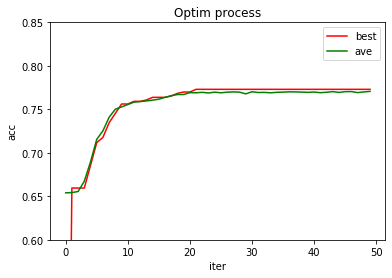

In [45]:
boundary = np.array([[0,0],[20, 2]])
ga = GA(10, 2, boundary, 50, [0.5, 0.1, 0.5], 7, 5)
ga.start()

In [477]:
b = np.array(b[:51])